# Optimizer-Method(Pytorch)

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
from sklearn import datasets
from utils import random_miniBatch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Load Data Set

In [2]:
def load_dataset(n_sample):
    """
    Load data set.
    Argument:
    --------
        n_sample: number of sample.
    Returns:
    -------
        X: training data.
        y: training labels,the shape os (n_sample,1)
    """
    np.random.seed(3)
    X, y = datasets.make_moons(n_samples=n_sample, noise=.15) #300 #0.2 
    # Visualize the data
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap=plt.cm.Spectral);
    
    
    return X,y.reshape(-1,1)

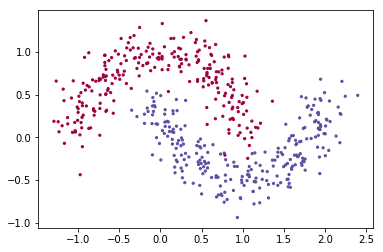

In [3]:
X,y = load_dataset(500)

我们按照7:3拆分training/validation set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Create Model

### 1. Create Forward Propagation

In [5]:
class Model(nn.Module):
    """
    Create forward model.
    """
    def __init__(self,layers):
        """
        Argument:
        --------
            layers: hidden layers's units.
        """
        nn.Module.__init__(self)
        self.layers = layers
        self.L = len(layers) # L: layers plus input layer units.
        # create Linear function. shape is (input units,output units)
        self.lines = nn.ModuleList([nn.Linear(self.layers[l],self.layers[l+1]) for l in range(self.L-1)])
        # change weights value to xavier normal
        [nn.init.xavier_normal_(line.weight) for line in self.lines]
        
    
    def forward(self,X):
        """
        forward propagation.
        
        NN structure: linear --> relu --> linear --> relu ... --> sigmoid
        
        Argument:
        ---------
            X: training data set,the shape is (num_sample,features)
        Return:
        ------
            X: output layer value
        """
        for l in range(self.L -1):
            X = self.lines[l](X)
            if l != self.L-2:
                X = torch.relu(X)
            else:
                X = torch.sigmoid(X)
                
        return X

### 2. Create Score function

构建评分函数

In [6]:
def score(model,cost,data,labels,is_loss=False):
    """
    Implement caculate train/vali data correct rate.
    
    Arguments:
    ---------
        model: Pytorch target model.
        cost: caculate loss value.
        data: score data.
        labels: score labbels.
        is_loss: caculate loss if it equal True,default False.
    Return:
    ------
        acc: accuracy for given data set.
        loss: loss value fro given data set. if give.
    """
    m = labels.shape[0]
    out = model.forward(data)
    
    predict = torch.round(out)
    
    acc = torch.eq(predict,labels).sum().item() / m
    if is_loss:
        loss = cost(out,labels)
        return acc,loss
    else:
        return acc

### 3. Create Optimizer Model

下面我们就开始构建目的为不同Optimizer的模型

**函数解释:**

[1] 

```python
with torch.no_grad():
    ...```
    
用于在训练的过程中检测训练样本和测试样本的正确率,当然由于我们没有必要让该数据计算反向梯度,所以我们使用```no_grad```.

[2]

```python
model = Model(layers=layers)```

创建Pytorch模型

[3]

```python
cost = nn.BCELoss()```

这里我们选择二分类交叉熵损失函数

[4]

```python
if mode == "SGD":
    ...
elif mode == "Momentum":
    ....```
    
通过控制```mode```参数选项来达到使用不同的Optimizer,其中在Pytorch中:

- [torch.optim.SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)包括SGD,Momentum,Nesterov Accelerated Gradient.


- [Adagrad](https://pytorch.org/docs/stable/optim.html#torch.optim.Adagrad),建议学习率为0.01.


- [Adadelta](https://pytorch.org/docs/stable/optim.html#torch.optim.Adadelta),这里不使用学习率,所以我们定义```lr=1,rho=0.9```.


- [RMSprop](https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop),使用建议学习率```lr=0.001```,默认值为```lr=0.01```,这里使用Pytorch的默认值的话就太大了.smoothing constant:```alpha=0.9```


- [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam),使用建议$\beta$,(0.9,0.999),使用建议学习率```lr=0.001```


In [15]:
def Optimizer_Model(layers,data,labels,val_data,val_labels,batch_size=64,epochs=4000,lr=None,beta_momentum=0.9,mode=None):
    """
    Implement main function.
    
    Arguments:
    ---------
        layers: hidden layers'units.
        data: training date set.
        labels: training data labels.
        val_data: validation data set.
        val_labels: validation data labels.
        batch_size: Mini-batch size, default 64.
        epochs:#Iterate default 4000.
        lr:learning rate, default None.
        beta_momentum: momentum parameter, learning decay, default 0.9.
        mode:choose optimizer method, 
            can shoose:1.SGD,2.Momentum,3.NAG,4.Adagrad,5.Adadelta,6.RMSProp,7.Adam,default None.
    
    Returns:
    -------
        loss_trains: training loss value in every epoch.
        loss_vals: validation data loss value in every epoch.
        acc_trains: training accuracy in every epoch.
        acc_vals: validation data accuracy in every epoch.
    """
    
    torch.manual_seed(5) # se random seed.
    m,n = data.shape
    layers.insert(0,n)
    
    with torch.no_grad():
        data_tensor = Variable(torch.from_numpy(data)).float()
        labels_tensor = Variable(torch.from_numpy(labels)).float()
        val_data_tensor = Variable(torch.from_numpy(val_data)).float()
        val_labels_tensor = Variable(torch.from_numpy(val_labels)).float()
        
    
    model = Model(layers=layers)
    
    cost = nn.BCELoss()
    
    if mode == "SGD":
        optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    elif mode == "Momentum":
        optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=beta_momentum)
    elif mode == "NAG":
        optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=beta_momentum,nesterov=True)
    elif mode == "Adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(),lr=lr)
    elif mode == "Adadelta":
        # using default parameter:lr=1,means not use lr,rho =0.9
        optimizer = torch.optim.Adadelta(model.parameters())
    elif mode == "RMSProp":
        # using alpha decay equal 0.9
        optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)
    elif mode == "Adam":
        optimizer = torch.optim.Adam(model.parameters())
        
    
    seed = 0
    loss_trains = []
    loss_vals = []
    acc_trains = []
    acc_vals = []
    
    # start training model.
    for epoch in range(epochs):
        batchs = random_miniBatch(batch_size,data,labels,seed)
        for mini_x,mini_y in batchs:
            x = Variable(torch.Tensor(mini_x))
            y = Variable(torch.Tensor(mini_y))
            # forward
            out = model.forward(x)
            # caculate loss
            loss = cost(out,y)
            # clear accumulate grad.
            optimizer.zero_grad()
            # backward
            loss.backward()
            # update
            optimizer.step()
        
        # score 
        acc_train = score(model,cost,data_tensor,labels_tensor)
        acc_val,val_loss = score(model,cost,val_data_tensor,val_labels_tensor,is_loss=True)

        loss_trains.append(loss)
        loss_vals.append(val_loss)
        acc_trains.append(acc_train)
        acc_vals.append(acc_val)
        print('[{}/{}] loss:{},acc train:{},val loss:{},acc val:{}\r'.format(epoch+1,epochs,loss,acc_train,val_loss,acc_val),end="",flush=True)
    
    return loss_trains,loss_vals,acc_trains,acc_vals

### SGD

In [8]:
layers = [5,2,1]
loss_trains_SGD,loss_vals_SGD,acc_trains_SGD,acc_vals_SGD = Optimizer_Model(layers=layers,
                                                            data=X_train,labels=y_train,
                                                            val_data=X_test,val_labels=y_test,
                                                            lr=0.0007,mode='SGD')

可以看到SGD的效果一般,training/validation data set的正确率都在85%左右.

### Momentum

In [9]:
layers = [5,2,1]
loss_trains_Momentum,loss_vals_Momentum,acc_trains_Momentum,acc_vals_Momentum = Optimizer_Model(layers=layers,
                                                                                                data=X_train,
                                                                                                labels=y_train,
                                                                                                val_data=X_test,
                                                                                                val_labels=y_test,
                                                                                                lr=0.0007,
                                                                                                mode='Momentum')

使用了Momentum之后,效果明显有好转,我们接下去使用Nesterov Accelerated Gradient(NAG)

### NAG

In [10]:
layers = [5,2,1]
loss_trains_NAG,loss_vals_NAG,acc_trains_NAG,acc_vals_NAG = Optimizer_Model(layers=layers,
                                                                            data=X_train,labels=y_train,
                                                                            val_data=X_test,val_labels=y_test,
                                                                            lr=0.0007,mode='NAG')

就当前样本和当前NN结构而言,两者几乎是一样的,但是按照理论而言NAG的效果会由于Momentum.

### Adagrad

In [11]:
layers = [5,2,1]
loss_trains_Adagrad,loss_vals_Adagrad,acc_trains_Adagrad,acc_vals_Adagrad = Optimizer_Model(layers=layers,
                                                                                            data=X_train,
                                                                                            labels=y_train,
                                                                                            val_data=X_test,
                                                                                            val_labels=y_test,
                                                                                            lr=0.01,
                                                                                            mode='Adagrad')

自使用方法Adagrad的效果没有NAG和Momentum好,但是也是比SGD优秀,因为Adagrad的分母累积会导致网络过早的降低学习率.

### Adadelta

In [12]:
layers = [5,2,1]
loss_trains_Adadelta,loss_vals_Adadelta,acc_trains_Adadelta,acc_vals_Adadelta = Optimizer_Model(layers=layers,
                                                                                                data=X_train,
                                                                                                labels=y_train,
                                                                                                val_data=X_test,
                                                                                                val_labels=y_test,
                                                                                                mode='Adadelta')

使用Adagrad的优化方法Adadelta之后,效果明显有变好.

### RMSProp

In [19]:
layers = [5,2,1]
loss_trains_RMSProp,loss_vals_RMSProp,acc_trains_RMSProp,acc_vals_RMSProp = Optimizer_Model(layers=layers,
                                                                                            data=X_train,
                                                                                            labels=y_train,
                                                                                            val_data=X_test,
                                                                                            val_labels=y_test,
                                                                                            lr=0.001,
                                                                                            mode='RMSProp')

RMSProp与Adadelta一样,都是做Adagrad的优化,对当前样本当前NN网络而言,RMSProp和Adadelta效果几乎一致.

### Adam

In [14]:
layers = [5,2,1]
loss_trains_Adam,loss_vals_Adam,acc_trains_Adam,acc_vals_Adam = Optimizer_Model(layers=layers,
                                                                                data=X_train,
                                                                                labels=y_train,
                                                                                val_data=X_test,
                                                                                val_labels=y_test,
                                                                                mode='Adam')

作为老大的Adam而言,效果是最优的.

### Plot Loss And Accuracy

### 1.1 Training/Validation Loss

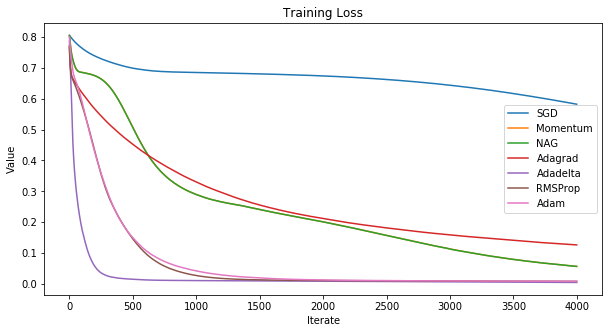

In [21]:
figure = plt.figure(figsize=(10,5))
plt.plot(loss_trains_SGD, label="SGD")
plt.plot(loss_trains_Momentum, label="Momentum")
plt.plot(loss_trains_NAG, label="NAG")
plt.plot(loss_trains_Adagrad, label="Adagrad")
plt.plot(loss_trains_Adadelta, label="Adadelta")
plt.plot(loss_trains_RMSProp, label="RMSProp")
plt.plot(loss_trains_Adam, label="Adam")
plt.title('Training Loss')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

从training loss中可以看出Adam的效果是比较优秀的,当然由于我们这里人为的减少学习率,使得SGD是这种效果,如果调大学习率,那么SGD的效果也是不错的.

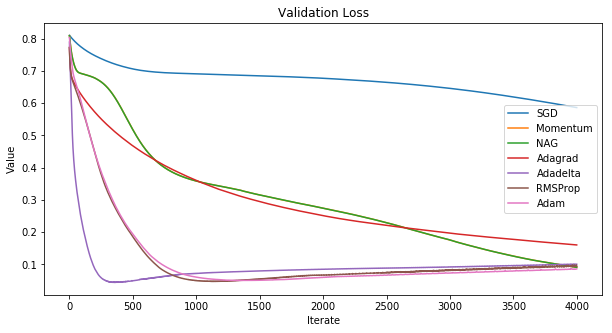

In [23]:
figure = plt.figure(figsize=(10,5))
plt.plot(loss_vals_SGD, label="SGD")
plt.plot(loss_vals_Momentum,label="Momentum")
plt.plot(loss_vals_NAG,label="NAG")
plt.plot(loss_vals_Adagrad,label="Adagrad")
plt.plot(loss_vals_Adadelta,label="Adadelta")
plt.plot(loss_vals_RMSProp,label="RMSProp")
plt.plot(loss_vals_Adam,label="Adam")
plt.title('Validation Loss')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

就验证集而言,可以发现Adadelta貌似出现了一点点过拟合的现象在大约400个epochs的时候,实际上RMSProp,Adam也有类似的感觉.

### 1.2 Training/Validation Accuracy

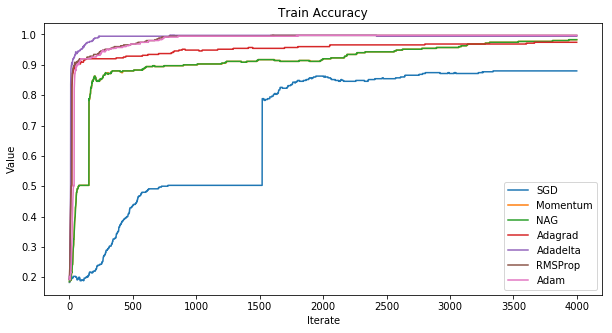

In [25]:
figure = plt.figure(figsize=(10,5))
plt.plot(acc_trains_SGD, label="SGD")
plt.plot(acc_trains_Momentum, label="Momentum")
plt.plot(acc_trains_NAG, label="NAG")
plt.plot(acc_trains_Adagrad, label="Adagrad")
plt.plot(acc_trains_Adadelta, label="Adadelta")
plt.plot(acc_trains_RMSProp, label="RMSProp")
plt.plot(acc_trains_Adam, label="Adam")
plt.title('Train Accuracy')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

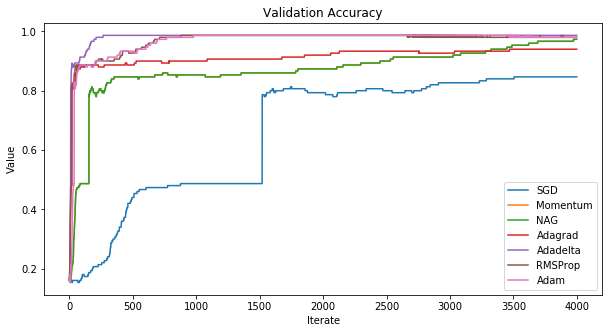

In [26]:
figure = plt.figure(figsize=(10,5))
plt.plot(acc_vals_SGD, label="SGD")
plt.plot(acc_vals_Momentum, label="Momentum")
plt.plot(acc_vals_NAG, label="NAG")
plt.plot(acc_vals_Adagrad, label="Adagrad")
plt.plot(acc_vals_Adadelta, label="Adadelta")
plt.plot(acc_vals_RMSProp, label="RMSProp")
plt.plot(acc_vals_Adam, label="Adam")
plt.title('Validation Accuracy')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

就验证集而言,Adadelta的收敛速度最快.但是Adam的表现效果也不错,RMSProp也是如此.

# Summary

实际上选择什么Optimizer是根据网络结构和数据本身而言的,各有各的优势.